In [1]:
# what are the steps taht we perform here

# [x] grab the data 
# [] run multiple gauss fits over the date with multiple initialization points 
# [] check what is the result for each run and which one gives the least error
# [] take only 70% of the points 
# [] write the result to the csv

# [] final consolidated table -> made per channel per type of gene

In [87]:
# imports
# general 
import os
import glob
from functools import reduce
import re
import csv as csv
# scientific 
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, datasets
from scipy.stats import norm
from scipy.optimize import curve_fit
import pandas as pd

In [3]:
# want to see the images inline
%matplotlib inline

In [75]:
# simple exp function
def f_x(x, A, b, x_0):
    return A*np.exp(-b*(x - x_0)*(x - x_0))

In [17]:
# function for loading one data-set
def load_data(file_path):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=1)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [28]:
# some folder magic 
folder = '/Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/'
N2_folder = 'N2-results/'
SEA12_folder = 'SEA12-results/'

In [29]:
# some const params for all graphs
binwidth = 0.01
# graph [xmin, xmax]
xmin = 0
xmax = 1

I_min: 0.13 I_max: 0.92


/Users/kkolyva/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


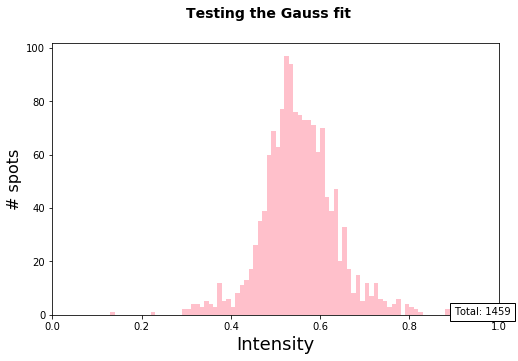

In [69]:
# for testing 
filepath = folder + N2_folder + 'C1/C1-N2_4.csv'

I = load_data(filepath)

fig = plt.figure(figsize=(8,5))
title = "Testing the Gauss fit"
fig.suptitle(title, fontsize=14, fontweight='bold')
    
plt.xlabel('Intensity', fontsize=18)
plt.ylabel('# spots', fontsize=16)

print("I_min:", min(I), "I_max:", max(I))

plt.hist(I, bins=np.arange(min(I), max(I) + binwidth, binwidth), color='pink');
plt.text(0.9, 0.1, "Total: " + str(I.shape[0]), color='black', bbox=dict(facecolor='white', alpha=1))

plt.xlim([xmin, xmax])

plt.legend(loc = 'upper right')

In [262]:
# possible labels 
stain = ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
stage = 'E' # only embryos
comment = '' # only empty ones

In [263]:
# important indices
stain_columns = ['C0_stain', 'C1_stain', 'C2_stain', 'C3_stain', 'C4_stain']
type_columns = ['C0_type', 'C1_type', 'C2_type', 'C3_type', 'C4_type']
stain_prefix = np.array([['C1-', 'C2-', 'C3-', 'C4-', 'C5-']])
ext = '.csv'
filename_column = 'new filename'

In [164]:
# read the db and parse images that we want to process
df = pd.read_csv(folder + "smFISH-database/SEA-12-Table 1.csv", sep=',', na_values=['']);
df.head()


(305, 24)

In [261]:
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())
# choose necessary stains
df_good = (df[type_columns] == stain[1]).loc[good_indices, :]
row, col = np.where(df_good)
new_prefix = np.repeat(stain_prefix, n_samples, axis=0)[row, col]
new_filename = df[filename_column].loc[good_indices].as_matrix()[row]


["{}{}".format(a_, b_) for a_, b_ in zip(new_prefix, new_filename)]

['C2-SEA-12_149',
 'C2-SEA-12_150',
 'C2-SEA-12_151',
 'C2-SEA-12_152',
 'C2-SEA-12_160',
 'C2-SEA-12_166',
 'C2-SEA-12_168',
 'C2-SEA-12_177',
 'C2-SEA-12_178',
 'C2-SEA-12_182',
 'C2-SEA-12_189',
 'C2-SEA-12_191',
 'C2-SEA-12_193',
 'C2-SEA-12_194',
 'C2-SEA-12_197',
 'C2-SEA-12_198',
 'C2-SEA-12_200',
 'C3-SEA-12_208',
 'C3-SEA-12_209',
 'C3-SEA-12_210',
 'C3-SEA-12_211',
 'C3-SEA-12_212',
 'C3-SEA-12_213',
 'C3-SEA-12_216',
 'C3-SEA-12_217',
 'C3-SEA-12_218',
 'C3-SEA-12_221',
 'C3-SEA-12_222',
 'C3-SEA-12_225',
 'C3-SEA-12_227',
 'C3-SEA-12_228',
 'C3-SEA-12_230',
 'C3-SEA-12_231',
 'C3-SEA-12_238',
 'C3-SEA-12_239',
 'C3-SEA-12_240',
 'C3-SEA-12_241',
 'C3-SEA-12_245',
 'C3-SEA-12_246',
 'C3-SEA-12_247',
 'C3-SEA-12_249',
 'C3-SEA-12_250',
 'C3-SEA-12_255',
 'C3-SEA-12_257',
 'C3-SEA-12_258',
 'C3-SEA-12_259',
 'C3-SEA-12_263',
 'C3-SEA-12_267',
 'C3-SEA-12_274',
 'C3-SEA-12_277',
 'C3-SEA-12_278',
 'C3-SEA-12_282',
 'C3-SEA-12_283',
 'C3-SEA-12_286',
 'C3-SEA-12_287',
 'C3-SEA-1

In [235]:
# good_indices = np.where(df['comment'].isnull() & df['stage'] == stage)[0] # NaN -> no defects in the image
# filter to have only *good* and *embryo* files
good_indices = np.logical_and((df['stage'] == stage).tolist() , (df['comment'].isnull()).tolist())

In [45]:
# general setup for pretty images 
full_folder = folder + N2_folder
print (full_folder)

dataset1 = []
for path in glob.iglob(full_folder + "C1/*"):
    dataset1.append(path)
dataset2 = []
for path in glob.iglob(full_folder + "C2/*"):
    dataset2.append(path)
dataset3 = []
for path in glob.iglob(full_folder + "C3/*"):
    dataset2.append(path)
    
# print(dataset)

/Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/


In [54]:
def create_title(path):
    # get the name of the initial image
    image_name = path.split("/")[8]
    # create the full title 
    title = image_name
    return title

In [55]:
# some presets for the graphs
labels = ["hello"]
colors = ["#ffc900"] # yellow

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_159.csv


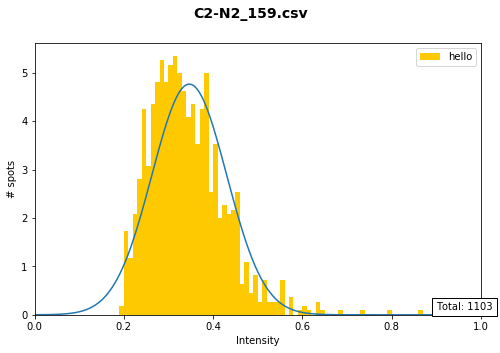

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_206.csv


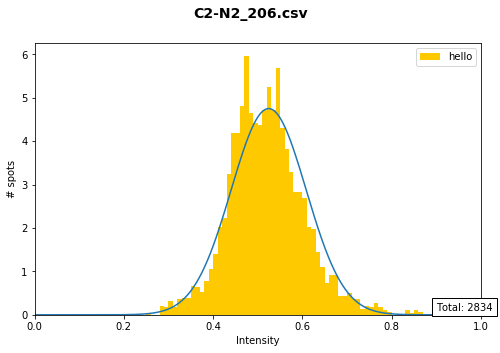

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_199.csv


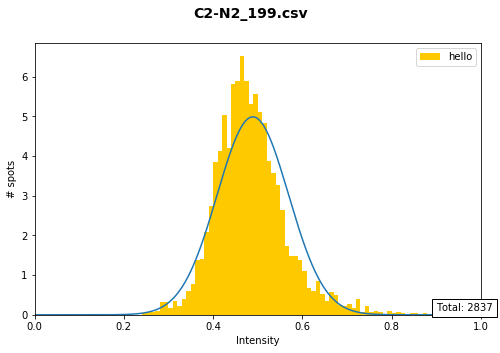

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_172.csv


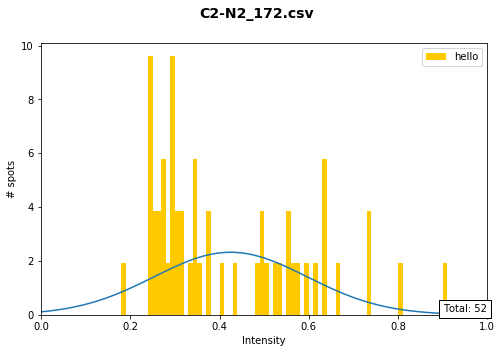

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_204.csv


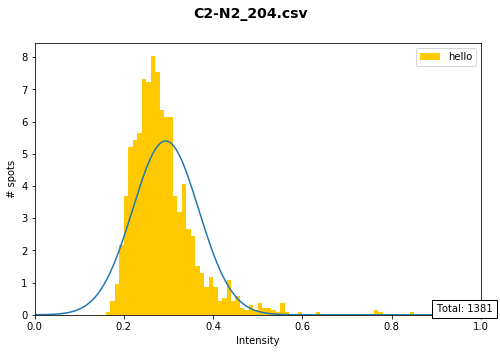

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_205.csv


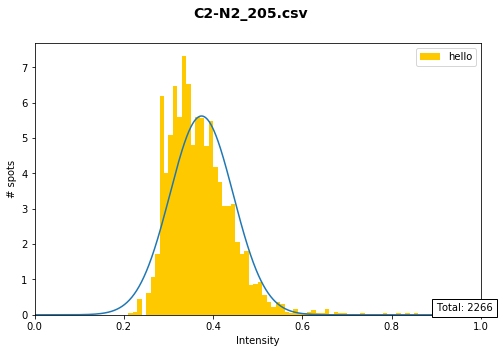

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_239.csv


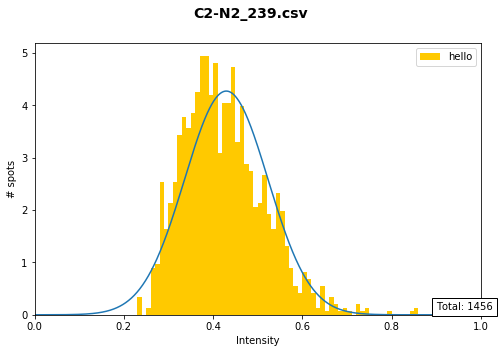

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_167.csv


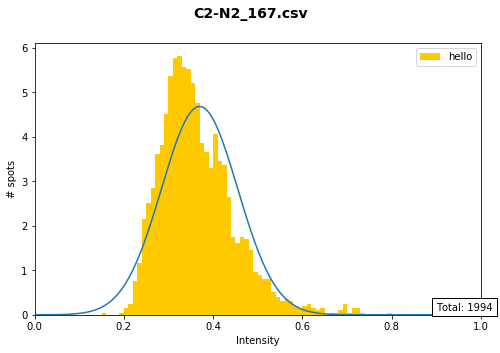

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_173.csv


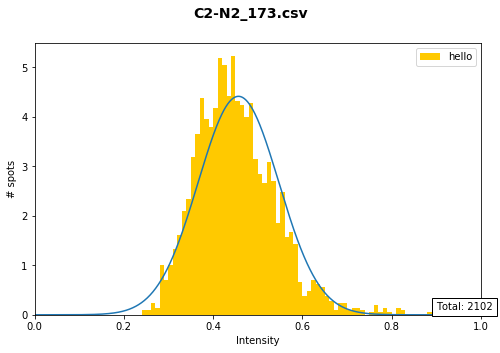

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_201.csv


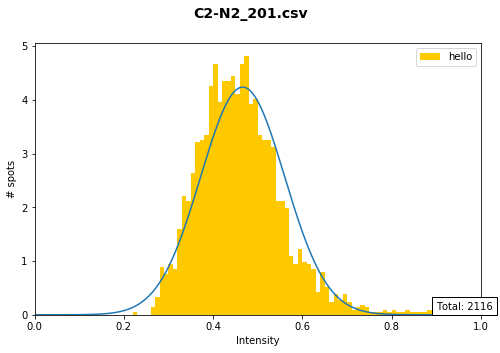

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_229.csv


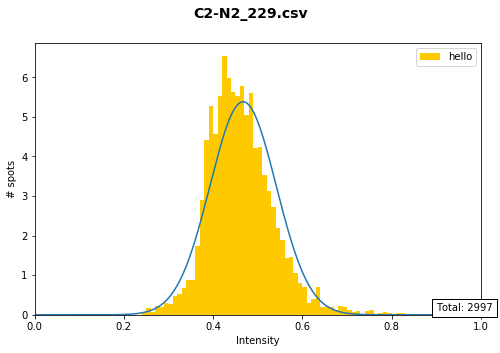

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_228.csv


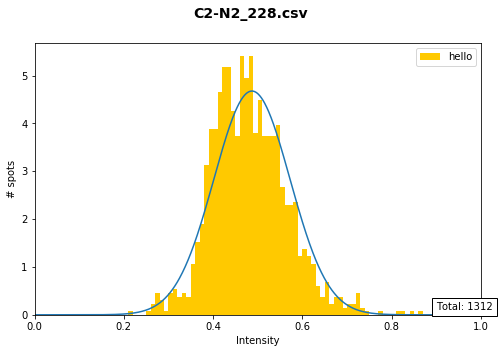

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_176.csv


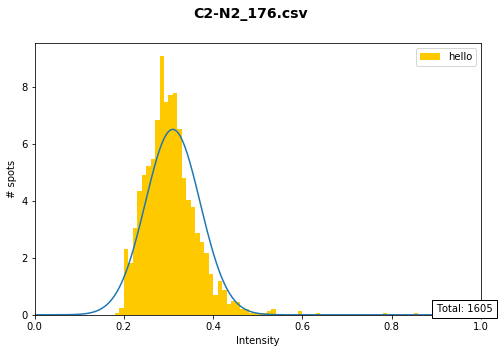

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_189.csv


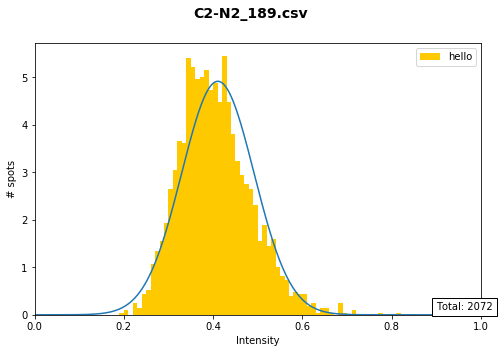

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_174.csv


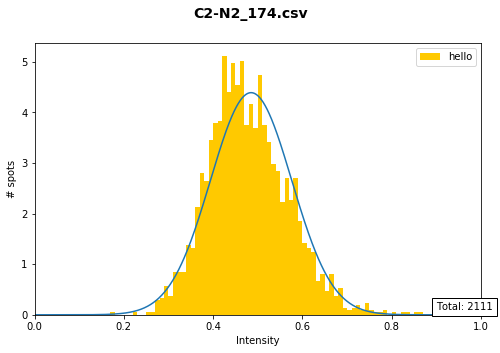

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_148.csv


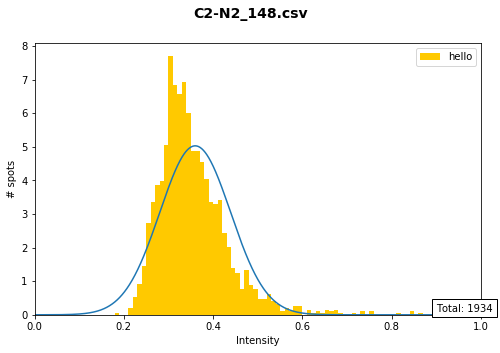

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_203.csv


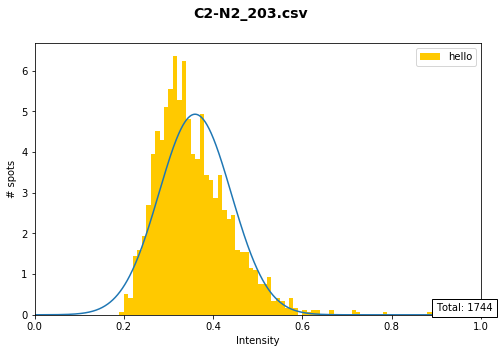

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_149.csv


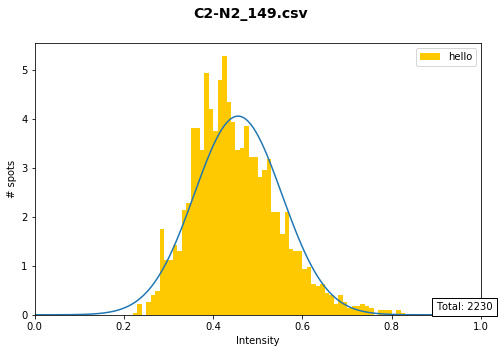

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_106.csv


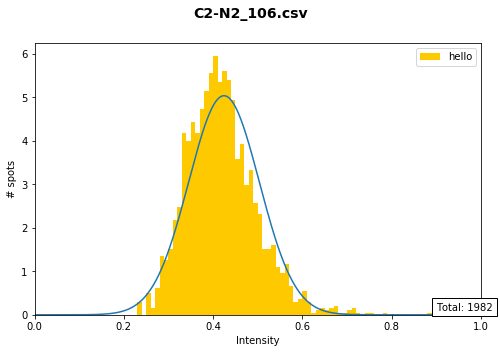

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_112.csv


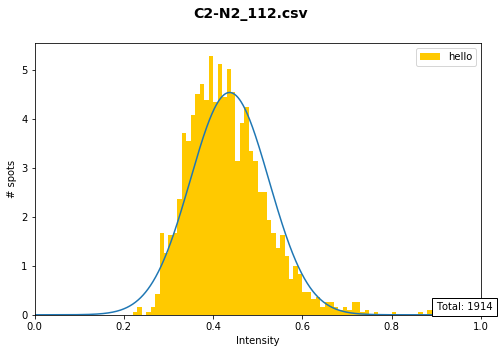

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_96.csv


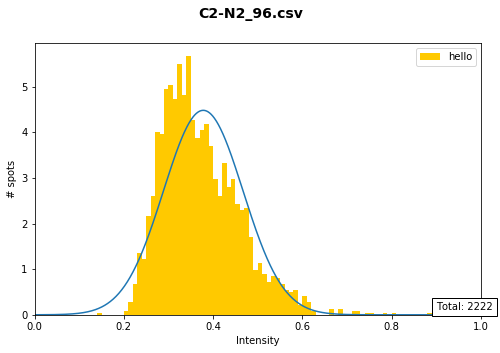

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_82.csv


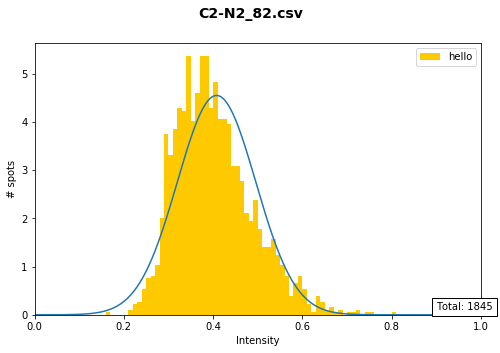

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_270.csv


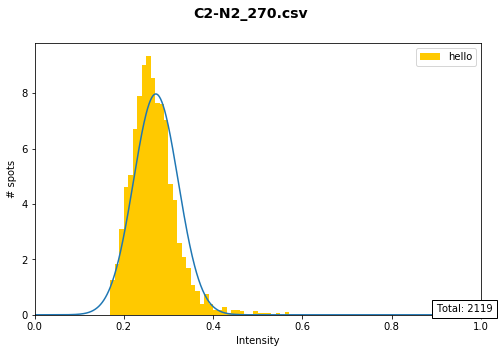

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_271.csv


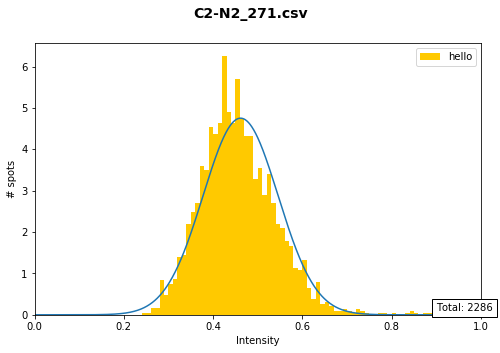

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_97.csv


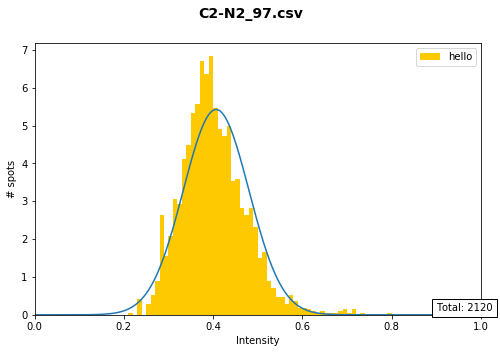

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_107.csv


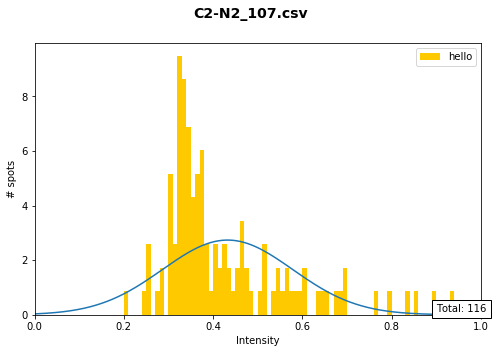

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_139.csv


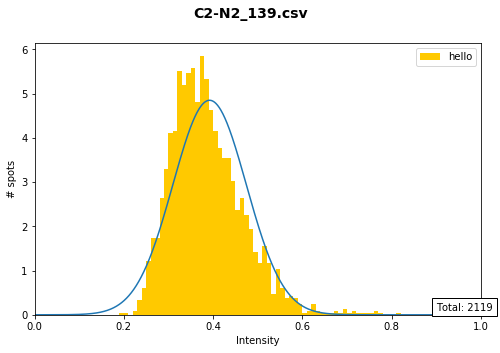

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_111.csv


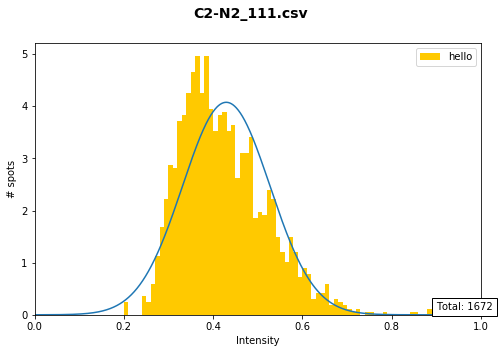

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_81.csv


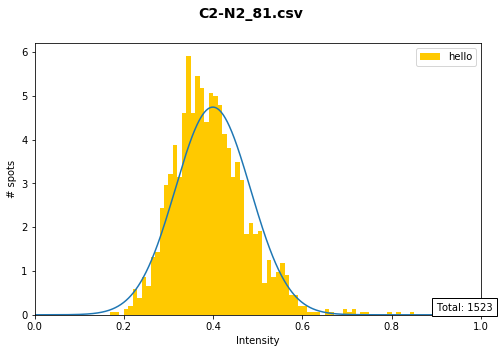

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_95.csv


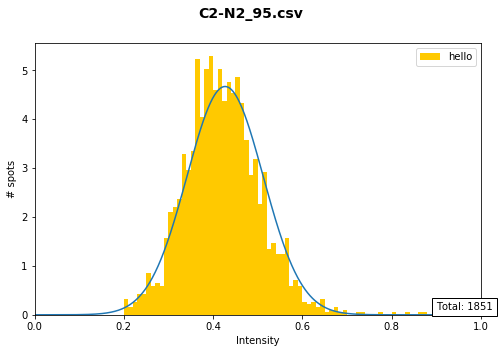

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_94.csv


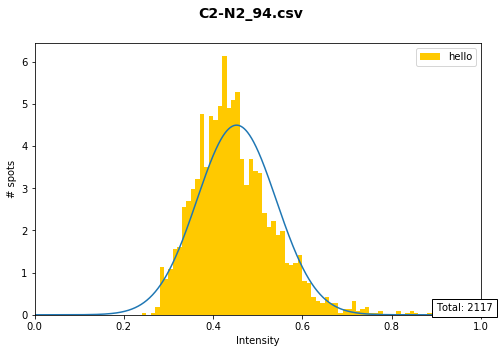

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_80.csv


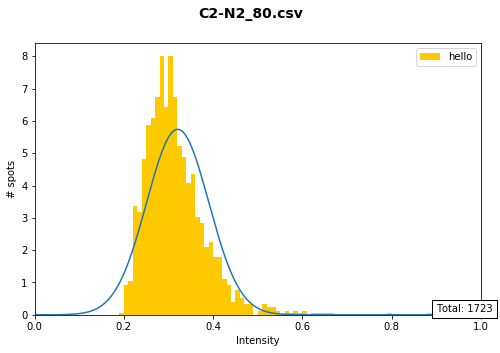

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_104.csv


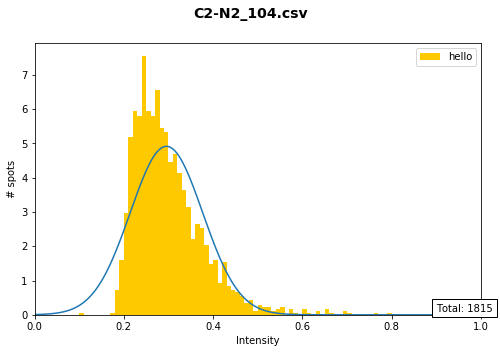

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_110.csv


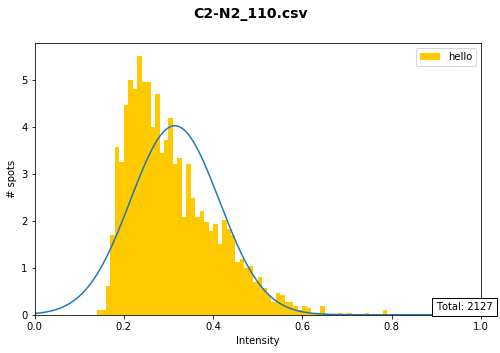

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_138.csv


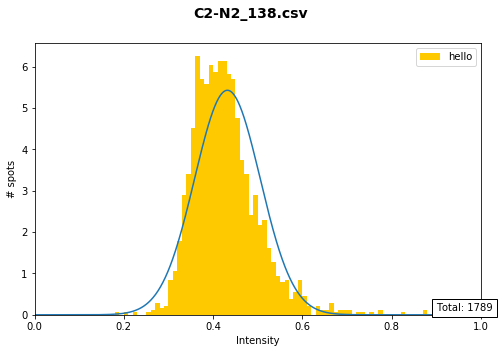

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_128.csv


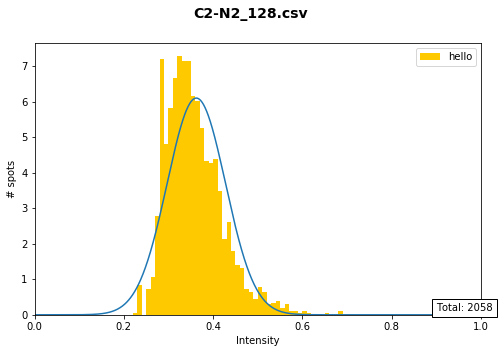

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_84.csv


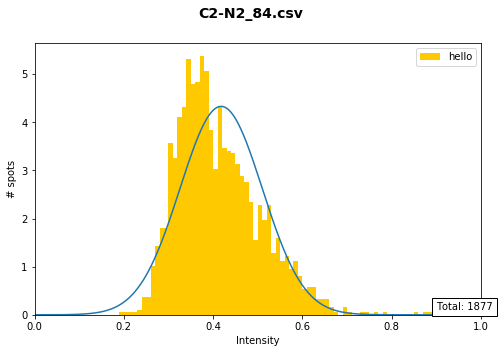

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_262.csv


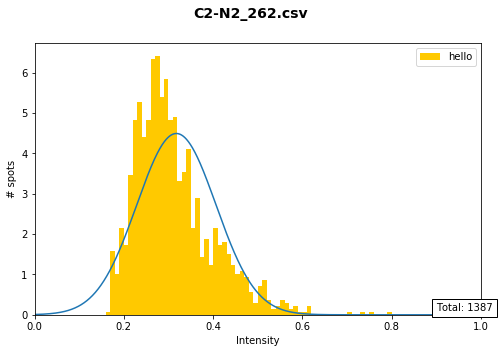

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_277.csv


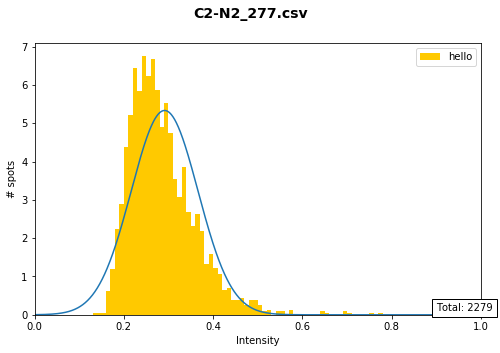

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_85.csv


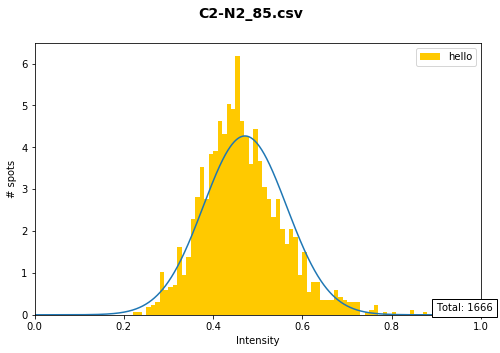

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_129.csv


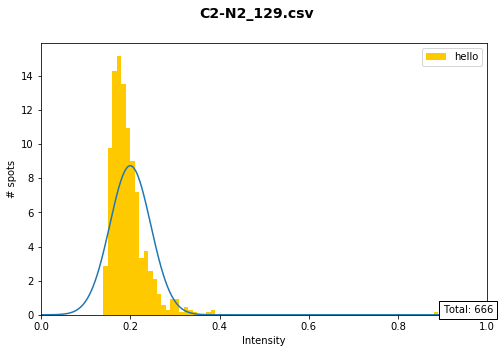

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_115.csv


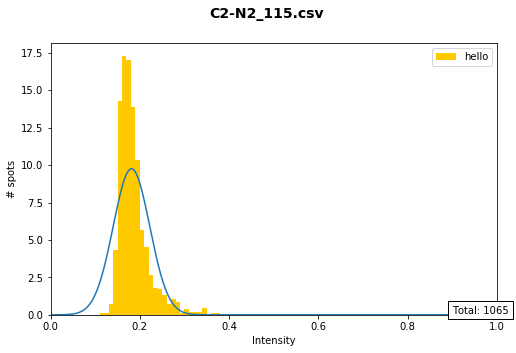

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_117.csv


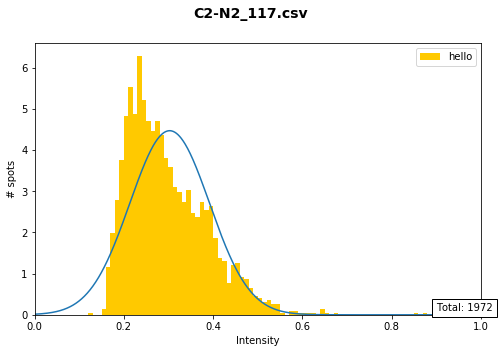

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_93.csv


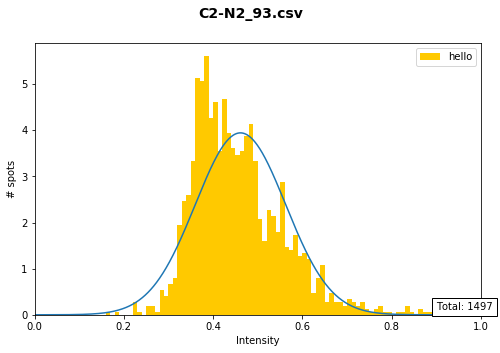

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_87.csv


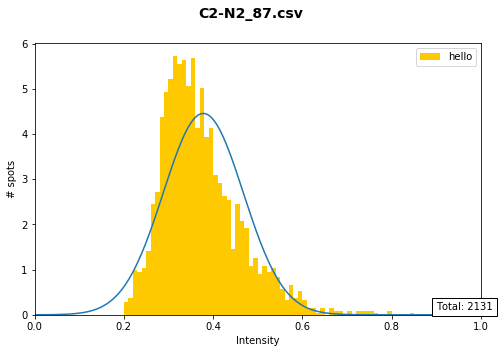

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_261.csv


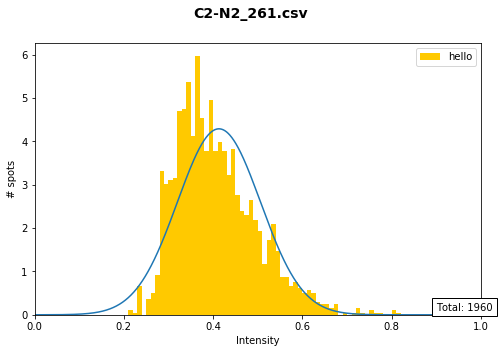

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_249.csv


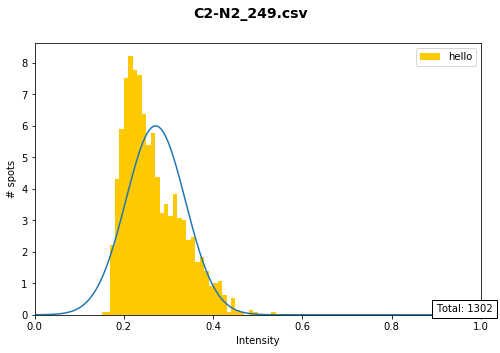

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_86.csv


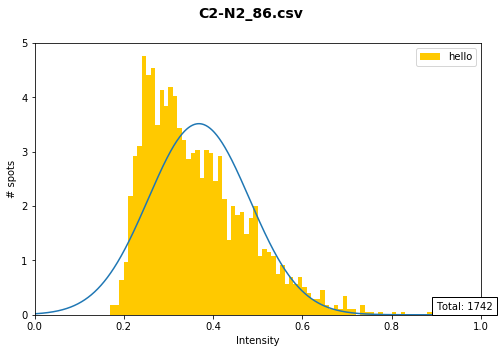

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_92.csv


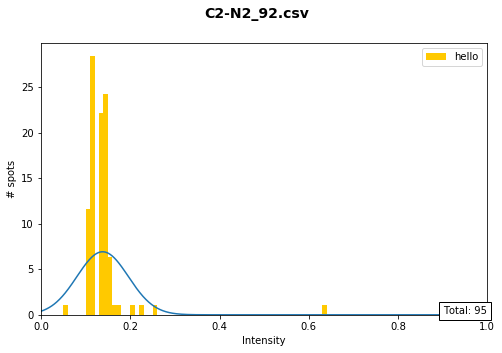

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_116.csv


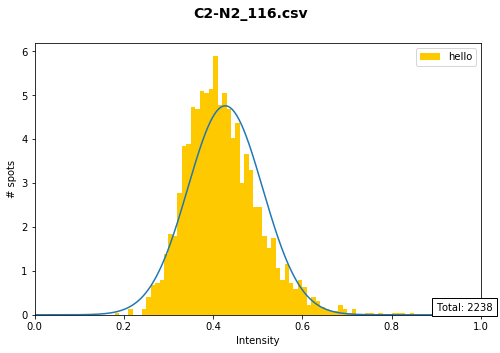

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_127.csv


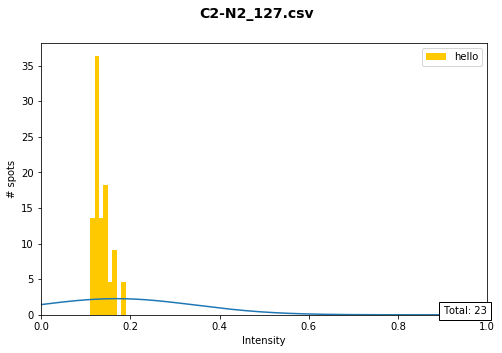

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_278.csv


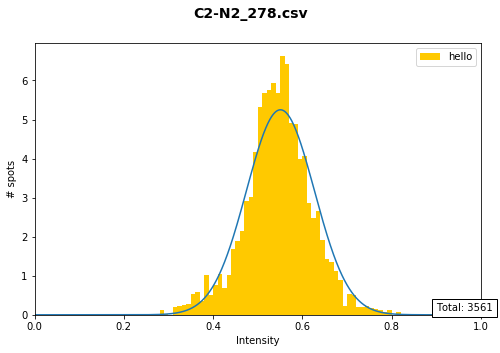

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_126.csv


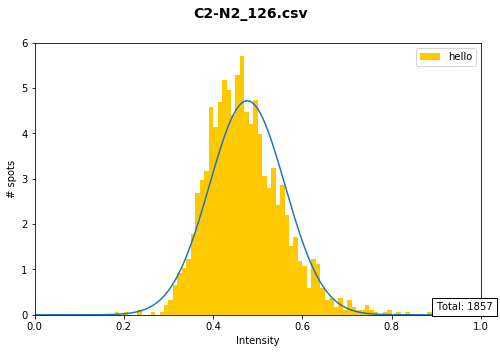

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_118.csv


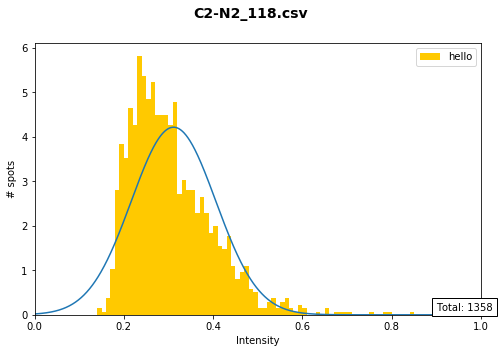

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_130.csv


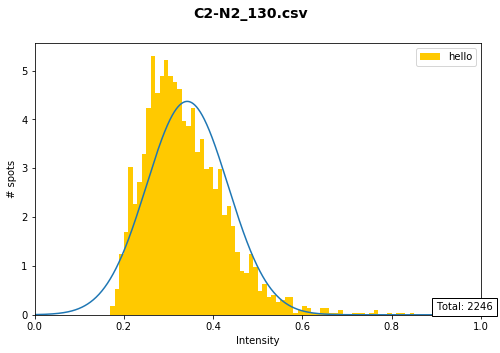

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_124.csv


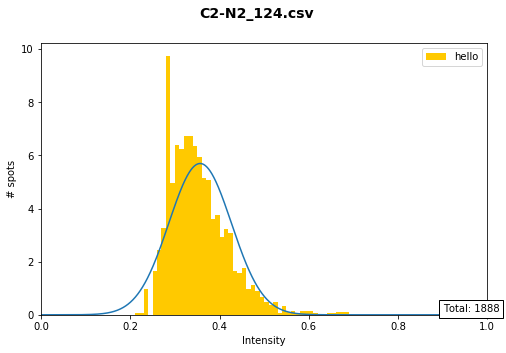

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_88.csv


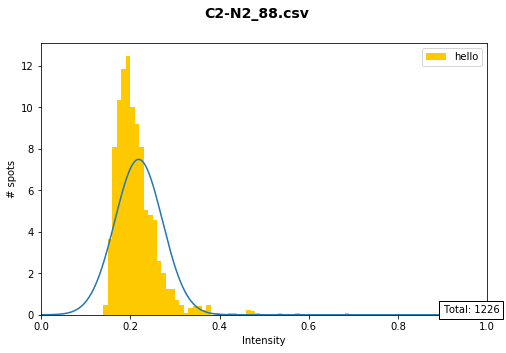

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_253.csv


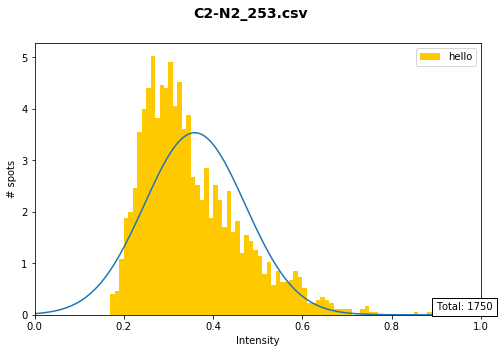

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_89.csv


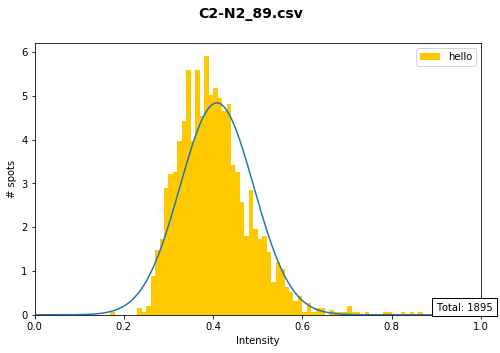

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_125.csv


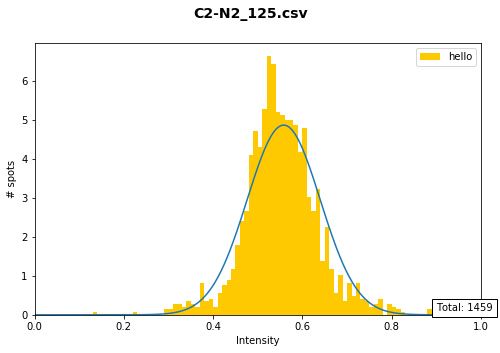

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_109.csv


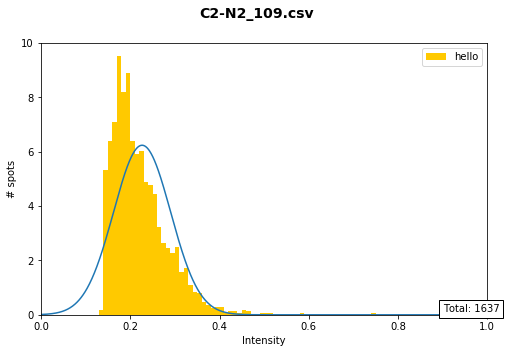

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_99.csv


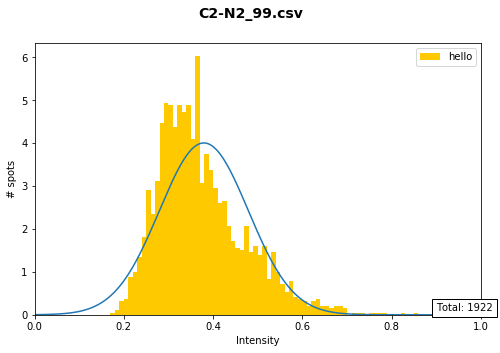

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_243.csv


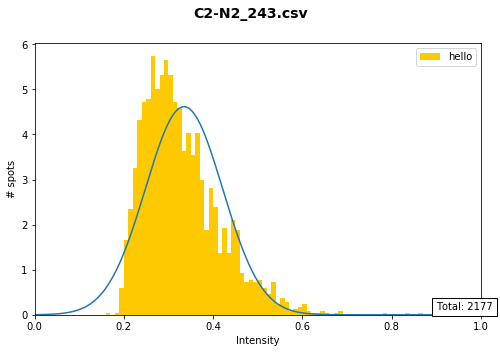

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_98.csv


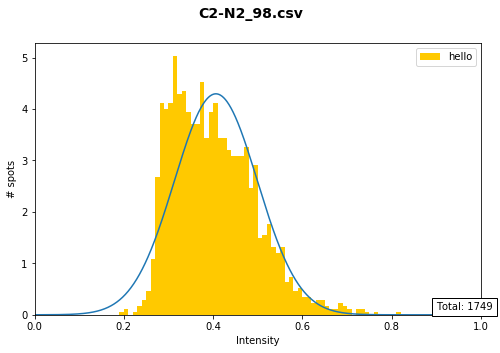

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_108.csv


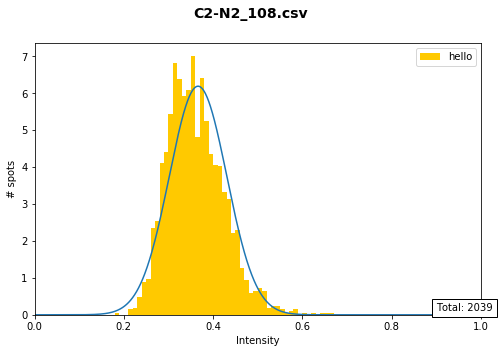

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_240.csv


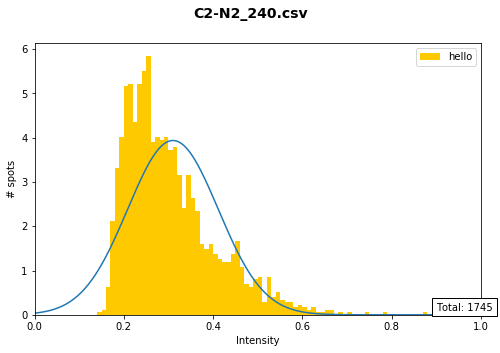

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_269.csv


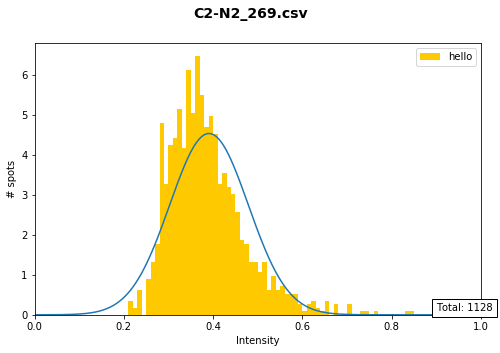

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_241.csv


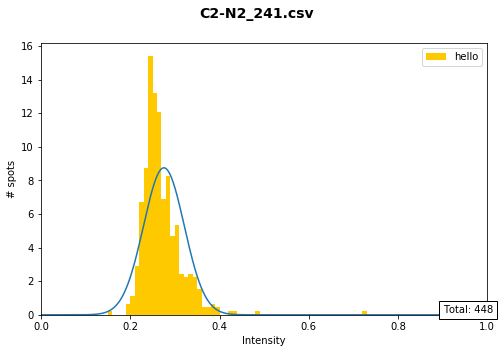

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_137.csv


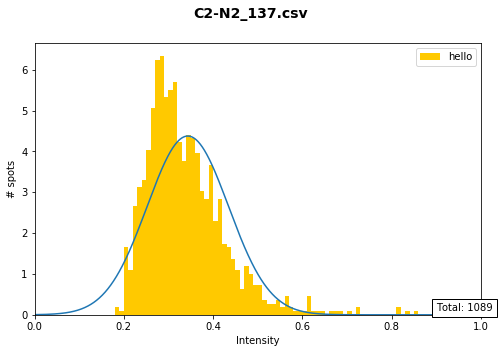

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_123.csv


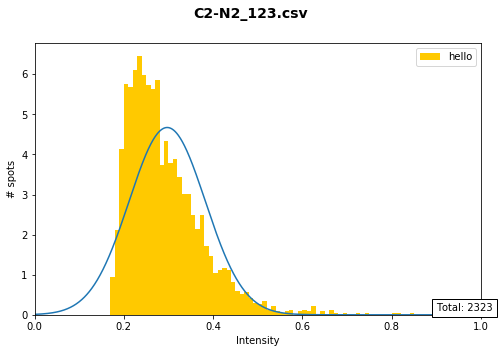

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_226.csv


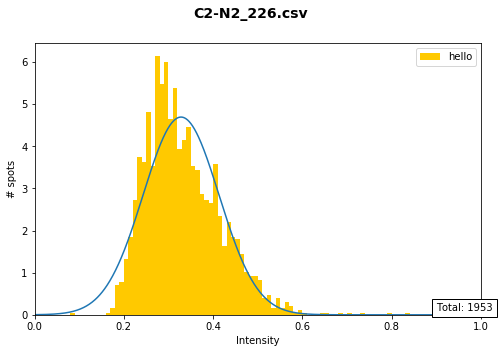

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_227.csv


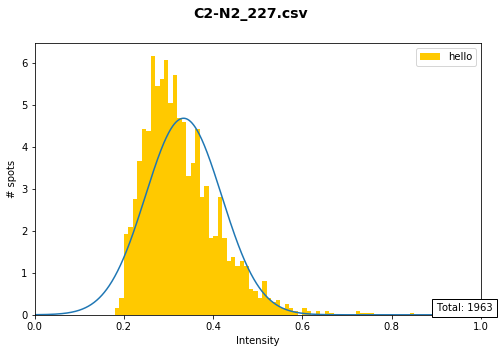

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_145.csv


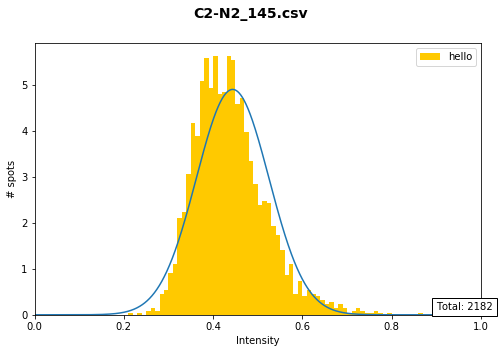

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_184.csv


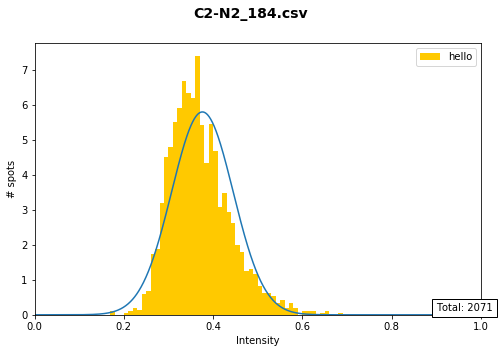

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_147.csv


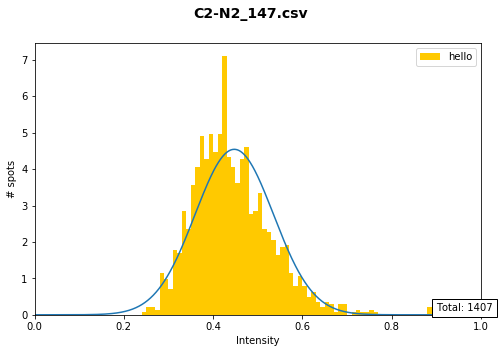

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_219.csv


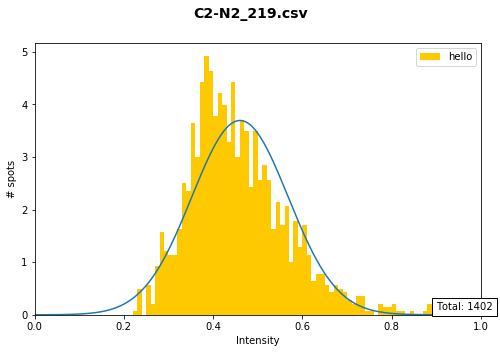

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_225.csv


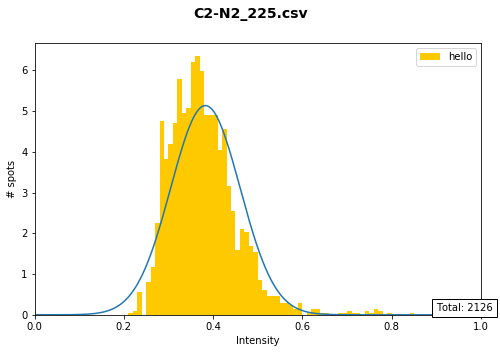

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_230.csv


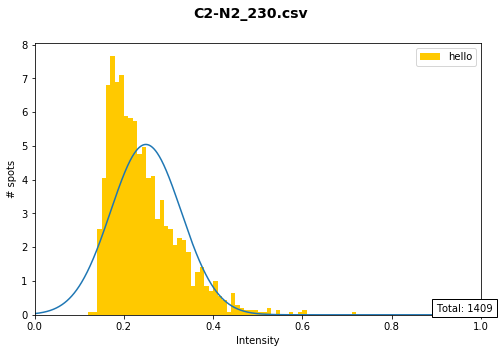

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_224.csv


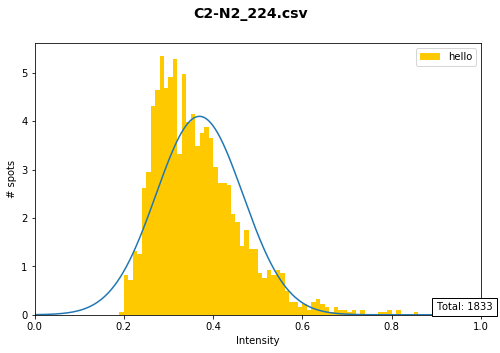

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_146.csv


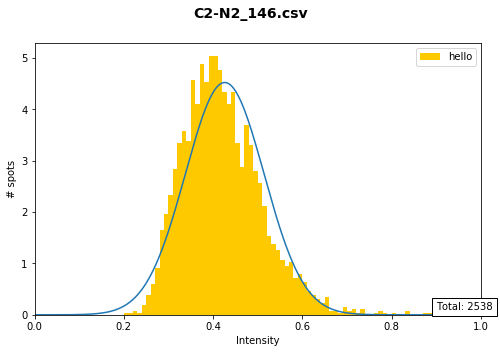

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_191.csv


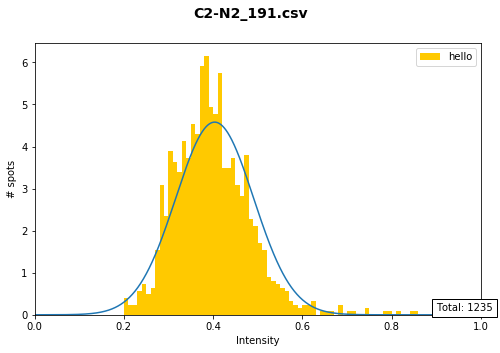

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_156.csv


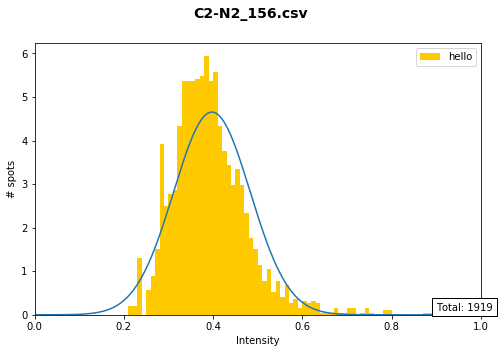

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_142.csv


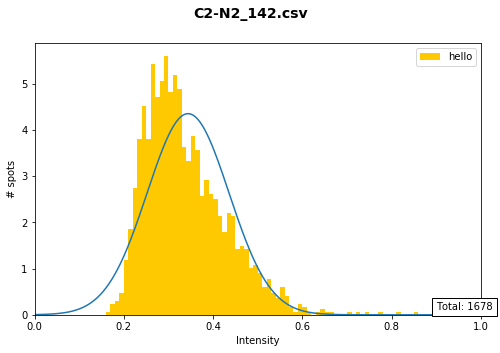

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_220.csv


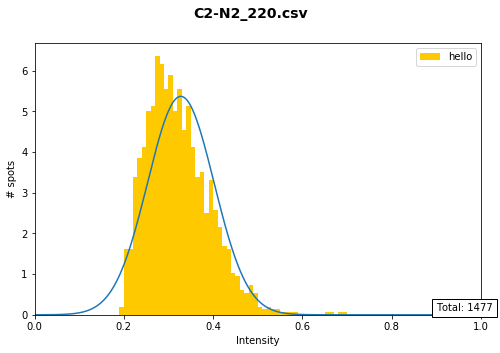

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_143.csv


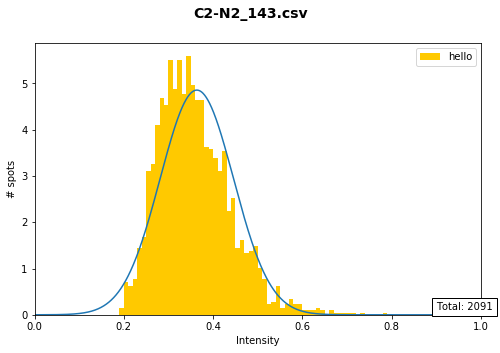

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_182.csv


/Users/kkolyva/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1645: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


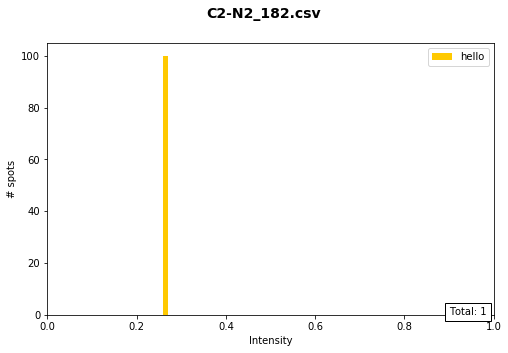

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_196.csv


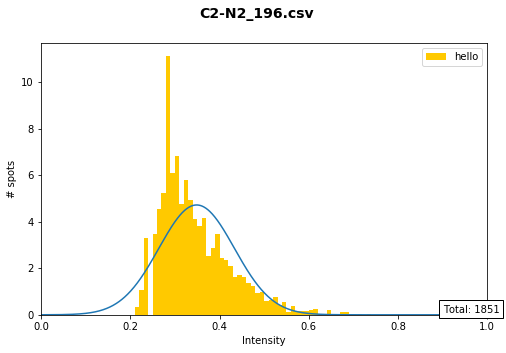

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_141.csv


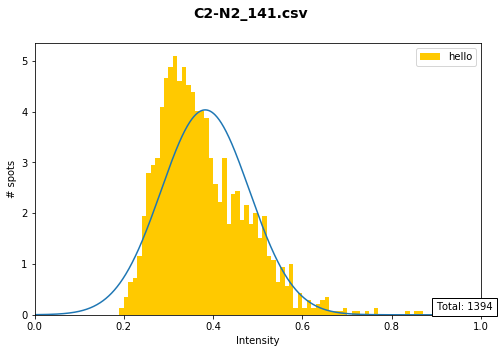

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_237.csv


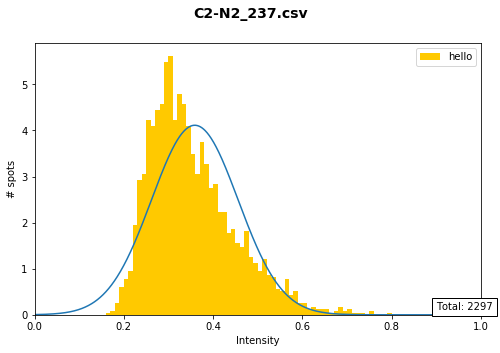

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_223.csv


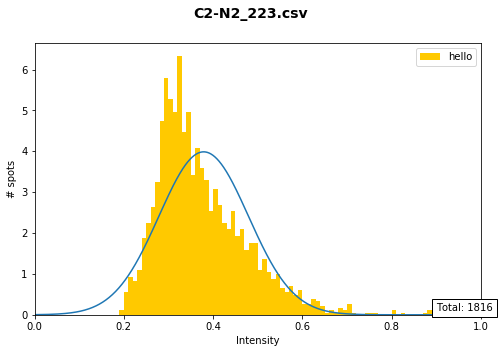

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_222.csv


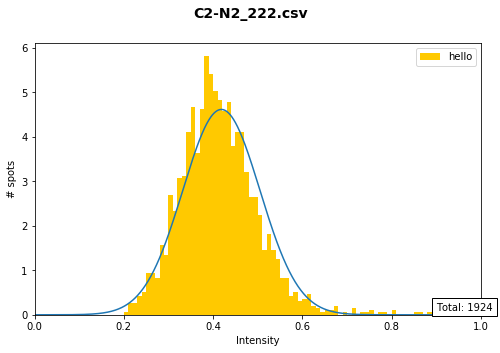

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_140.csv


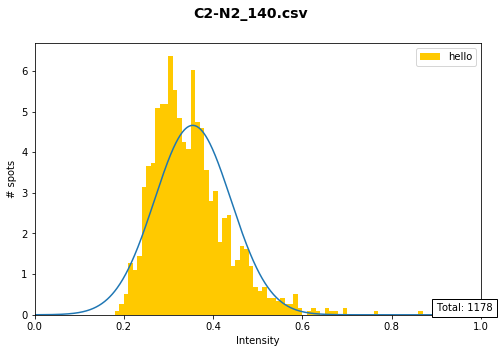

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_197.csv


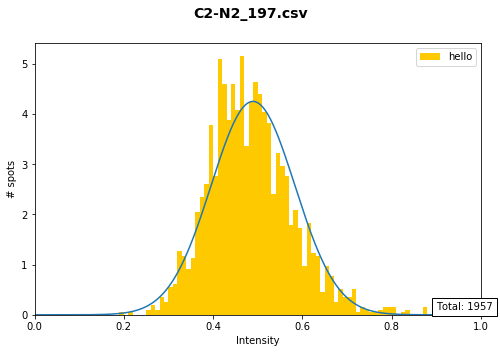

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C2/C2-N2_183.csv


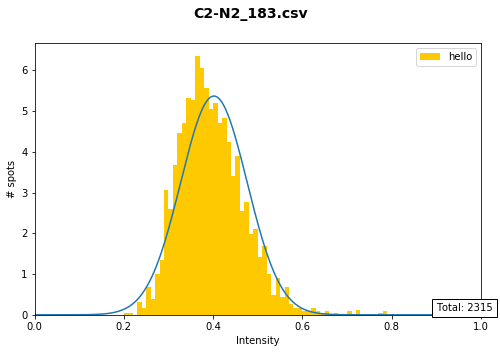

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_243.csv


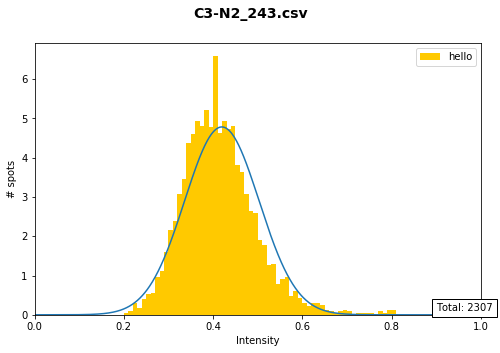

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_240.csv


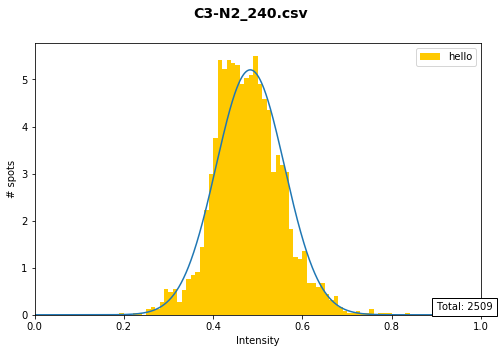

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_269.csv


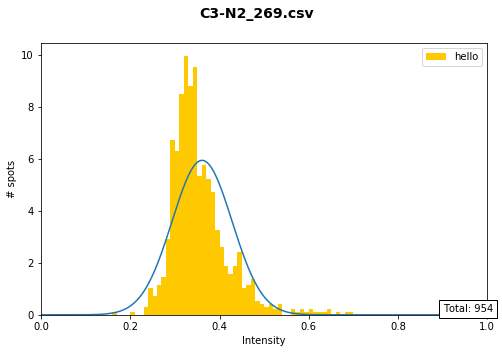

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_241.csv


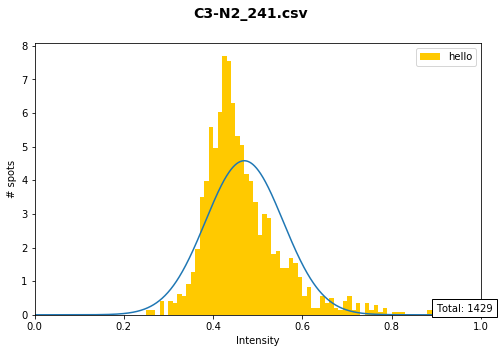

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_278.csv


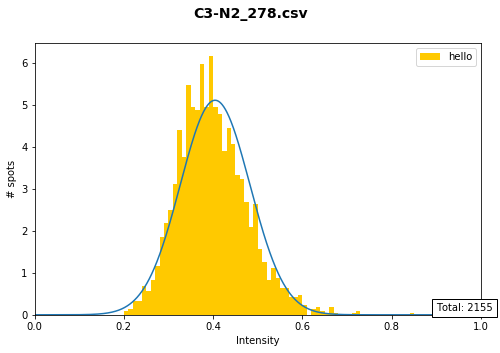

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_253.csv


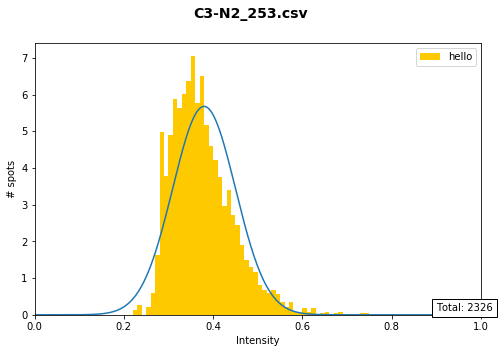

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_220.csv


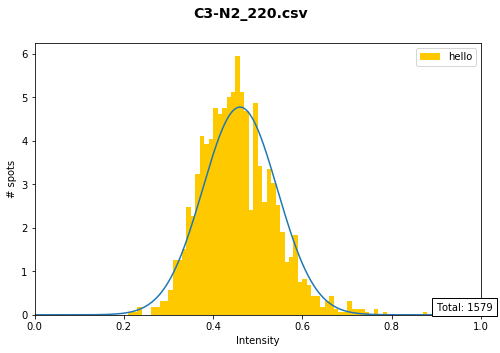

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_156.csv


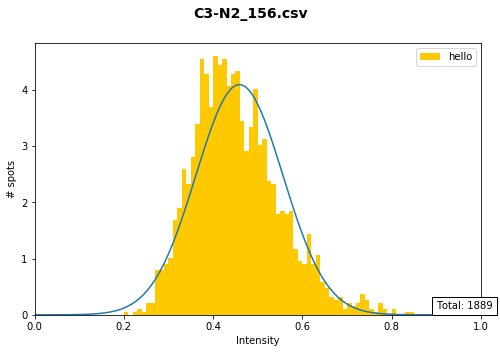

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_223.csv


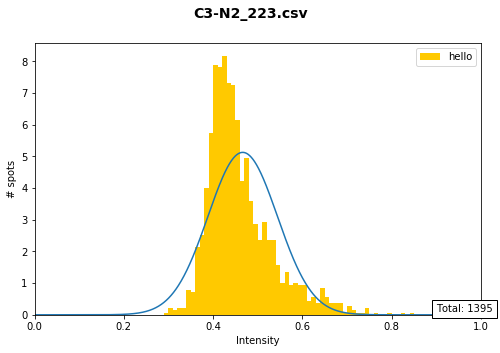

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_237.csv


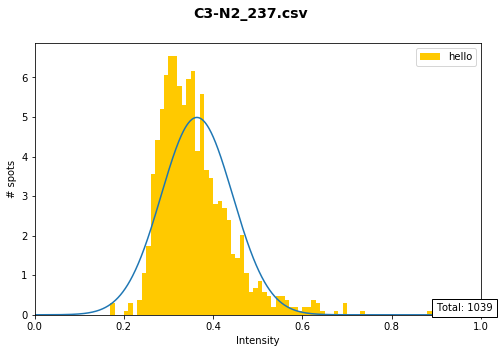

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_196.csv


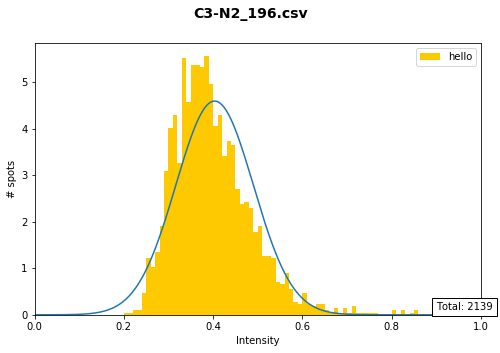

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_182.csv


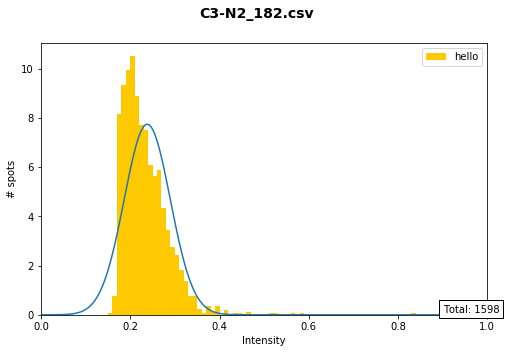

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_183.csv


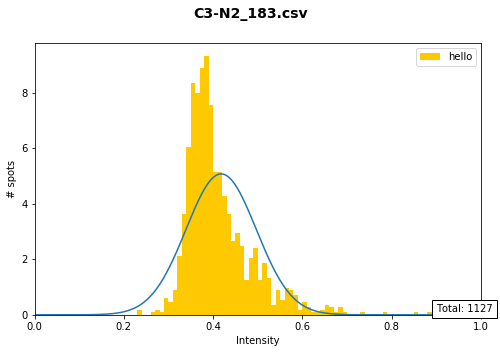

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_197.csv


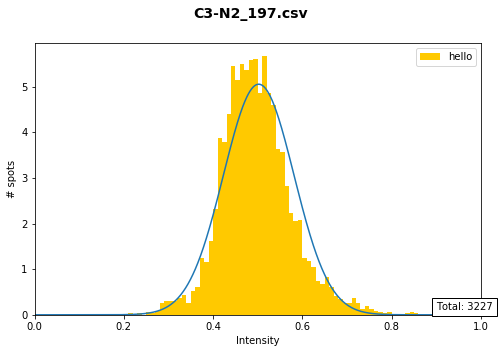

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_222.csv


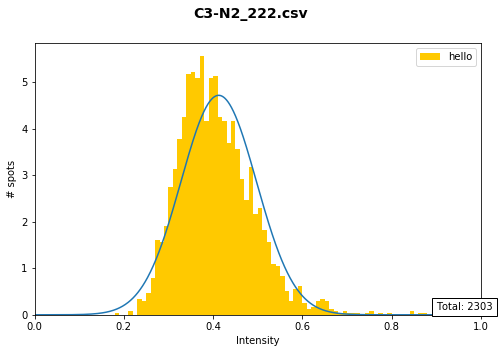

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_226.csv


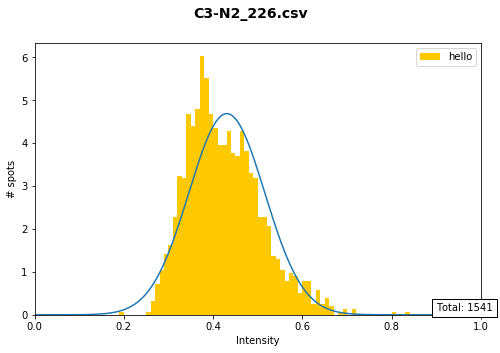

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_227.csv


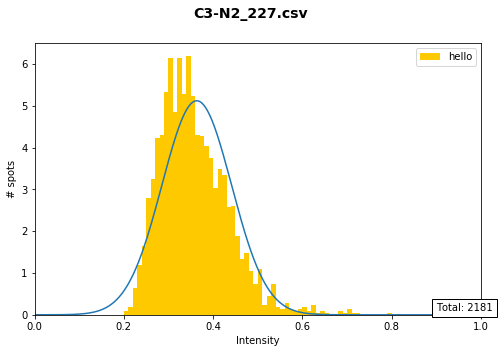

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_219.csv


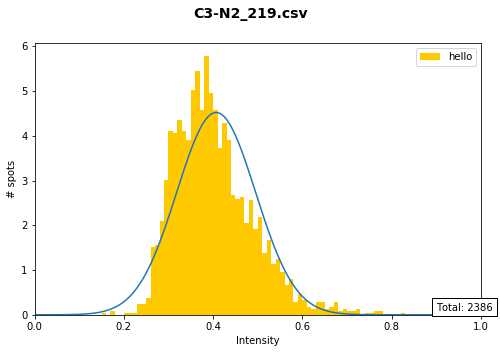

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_225.csv


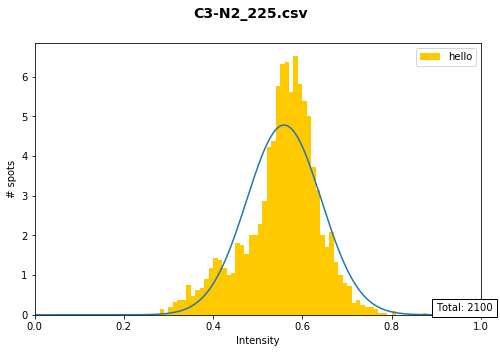

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_184.csv


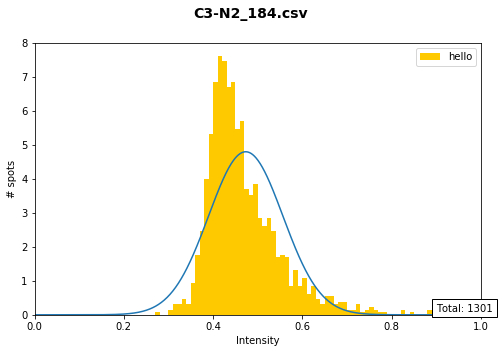

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_191.csv


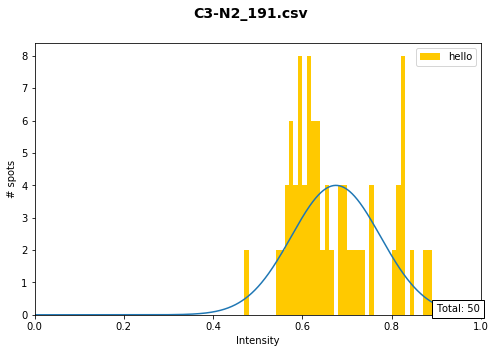

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_224.csv


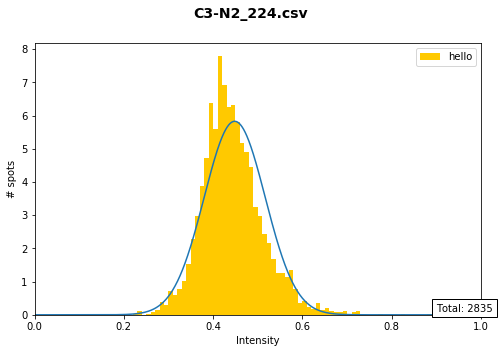

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_230.csv


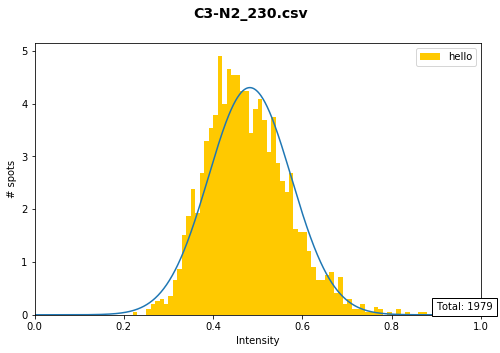

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_201.csv


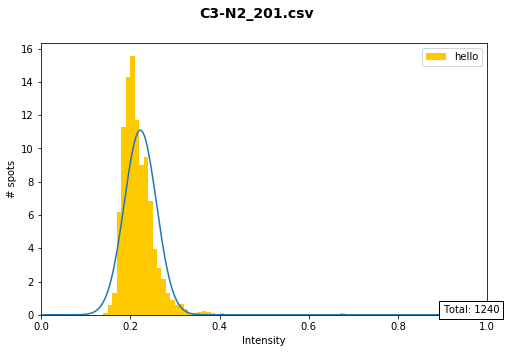

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_229.csv


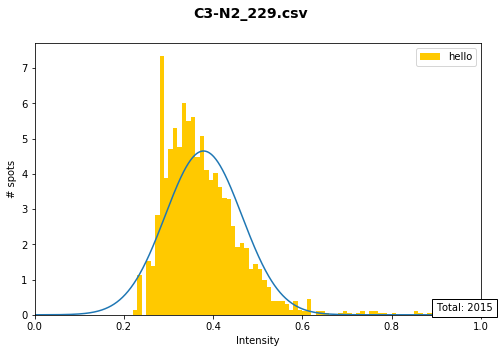

Processing: /Users/kkolyva/Desktop/resample/2018-04-03-results-radial-symmetry/N2-results/C3/C3-N2_176.csv


IndexError: list index out of range

In [81]:
# have to perform this step multiple times and choose the best one 
# perform n_fits with different initial parameters
# n_fits = 10

# actual plotting 
dataset = dataset2
for idx in range(0, len(dataset)):
    # create the canvas
    fig = plt.figure(figsize=(8,5))
    title = create_title(dataset[idx])

    fig.suptitle(title, fontsize=14, fontweight='bold')

    # feedback
    print("Processing:", dataset[idx])       
    # load the data and scale it accordingly
    I = load_data(dataset1[idx])
        
    # TODO: threshold the data 
    # TODO: smoothen the data
    # I_res = running_average_strides(I)
    I_res = I
    (h_mu, h_sigma) = norm.fit(I_res)
        
    # create one of the subplot images
    bins=np.arange(min(I), max(I) + binwidth, binwidth)
    plt.hist(I, bins=np.arange(min(I), max(I) + binwidth, binwidth), color=colors, label=labels, normed=True)
    
    x = np.linspace(xmin, xmax, 1103)
    # y = f_x(x, 1, 1 / (h_sigma*h_sigma*2), h_mu)
    
#     n_fits = 10
#     for j in range(0, n_fits):
#         popt, pcov = curve_fit(f_x, x, I, p0=[1, 1, 0.1*j])
    y = norm.pdf(x, h_mu, h_sigma)
    plt.plot(x,y)
          
    # reasonable adjustments to make the data look nicer
    plt.xlabel('Intensity')
    plt.ylabel('# spots')
    plt.text(0.9, 0.1, "Total: " + str(I.shape[0]), color='black', bbox=dict(facecolor='white', alpha=1))
    plt.xlim([xmin, xmax])
    plt.legend(loc = 'upper right')

    
#     if not os.path.exists(folder_path + "histograms/" + image):
#         os.makedirs(folder_path + "histograms/" + image)
    # plt.savefig(folder_path + "histograms/" + image + "/" + title + ".png")
        
    plt.show()
    # break